# Problem Statement

In this project, I work on a supervised regression problem where the goal is to
predict house prices at a district level using demographic and housing-related features.

The dataset includes information such as income levels, age of properties,
room composition, population in the neighborhood, and occupancy patterns.
These are commonly used signals in real-world housing price estimation.

To make the problem more realistic, the dataset intentionally includes noise,
missing values, and partially obfuscated features. This reflects the kind of
imperfect data usually seen in large real-world housing datasets.

Model performance is evaluated using RMSE, since large prediction errors
are especially costly in housing price estimation.



# Exploring the data first

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/house-price-prediction-iitm/estate_train.csv
/kaggle/input/house-price-prediction-iitm/estate_sample_submission.csv
/kaggle/input/house-price-prediction-iitm/estate_test.csv


In [2]:
train = pd.read_csv('/kaggle/input/house-price-prediction-iitm/estate_train.csv')
test = pd.read_csv('/kaggle/input/house-price-prediction-iitm/estate_test.csv')
submission = pd.read_csv('/kaggle/input/house-price-prediction-iitm/estate_sample_submission.csv')

In [3]:
train.head()

,IncomeLevel,PropertyAge,TotalRooms,TotalBedrooms,NeighborhoodPop,AvgOccupancy,Latitude,Longitude,TargetPrice,PropertyID,RoomsPerHousehold,BedroomsRatio
0,3.287977,32.970198,5.128150,0.990769,2339.474039,3.739113,32.71,-117.03,1.030,PROP_14196,1.359130,0.200576
1,3.804601,49.030192,4.372696,1.040469,1269.383596,1.429576,33.77,-118.16,3.821,PROP_08267,2.573820,0.232703
2,4.193302,NaN,5.718626,0.989809,865.436104,2.481219,34.66,-120.48,1.726,PROP_17445,2.073224,0.174486
3,2.029509,36.255617,4.131418,1.032285,1455.381923,3.914447,32.69,-117.11,0.934,PROP_14265,1.002116,0.258269
4,3.540823,42.918534,6.270531,1.147146,895.050628,2.681969,36.78,-119.80,0.965,PROP_02271,2.725400,0.180940


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IncomeLevel        16512 non-null  float64
 1   PropertyAge        15199 non-null  float64
 2   TotalRooms         16512 non-null  float64
 3   TotalBedrooms      16512 non-null  float64
 4   NeighborhoodPop    16512 non-null  float64
 5   AvgOccupancy       16512 non-null  float64
 6   Latitude           16512 non-null  float64
 7   Longitude          16512 non-null  float64
 8   TargetPrice        16512 non-null  float64
 9   PropertyID         16512 non-null  object 
 10  RoomsPerHousehold  16512 non-null  float64
 11  BedroomsRatio      16512 non-null  float64
dtypes: float64(11), object(1)
memory usage: 1.5+ MB


### Dataset overview

The training dataset contains 16,512 rows and 12 columns.
Each row represents one district-level housing record.

Only one feature `PropertyAge` contains missing values.
Since this column has a great importance is our project, I will not remove the entire column, but proceed with imputation.

All the columns are numerical except `PropertyID`



In [5]:
train.describe()

,IncomeLevel,PropertyAge,TotalRooms,TotalBedrooms,NeighborhoodPop,AvgOccupancy,Latitude,Longitude,TargetPrice,RoomsPerHousehold,BedroomsRatio
count,16512.000000,15199.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,3.880870,28.610537,5.435311,1.096797,1426.441888,3.097123,35.643149,-119.582290,2.071947,1.980582,0.212858
std,1.906229,12.604955,2.387346,0.433573,1137.594296,11.589701,2.136665,2.005654,1.156226,1.125818,0.057995
min,0.409295,0.567139,0.973695,0.329765,-44.578990,0.579087,32.550000,-124.350000,0.149990,0.002547,0.100000
25%,2.564153,18.195306,4.450483,1.005528,788.555955,2.362349,33.930000,-121.810000,1.198000,1.526243,0.175178
50%,3.544769,28.747429,5.238836,1.049505,1169.707835,2.835532,34.260000,-118.510000,1.798500,1.941541,0.202808
75%,4.779065,37.045296,6.064049,1.102542,1730.584980,3.364962,37.720000,-118.010000,2.651250,2.300615,0.239501
max,15.113356,53.490497,141.875493,25.630214,35739.248210,1243.662159,41.950000,-114.310000,5.000010,52.033333,1.000000


Some features vary a lot across districts, especially population,
occupancy, and room counts. This suggests that districts differ
significantly in size and structure.
There are also some extreme values, such as very high occupancy
and unusually large room counts. These are likely the result
of injected noise in the dataset.

There are some negative values found in `NeighborhoodPop`.

In [6]:
train.duplicated().sum()

np.int64(0)

There are no duplicates present in columns

## Visualizations

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

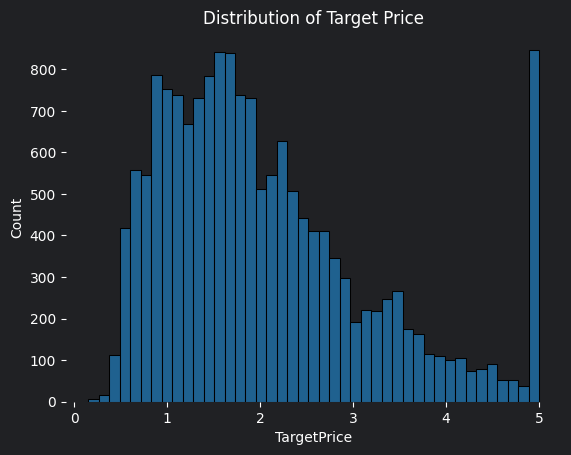

In [8]:
ax=sns.histplot(x='TargetPrice', data=train, palette='crest')
ax.set_facecolor('#202124')
plt.gcf().set_facecolor('#202124')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_xlabel("TargetPrice", color='white')
ax.set_ylabel("Count", color='white')
for spine in ax.spines.values():
    spine.set_visible(False)
plt.title("Distribution of Target Price", color='white')
plt.show()

The target price distribution is clearly right-skewed.
Most districts fall in the lower price range, with a long tail
of higher-priced areas. 

{'whiskers': [<matplotlib.lines.Line2D at 0x79f023318050>,
 'caps': [<matplotlib.lines.Line2D at 0x79f0233186b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x79f023307d70>],
 'medians': [<matplotlib.lines.Line2D at 0x79f023318b90>],
 'fliers': [<matplotlib.lines.Line2D at 0x79f023318ec0>],
 'means': []}

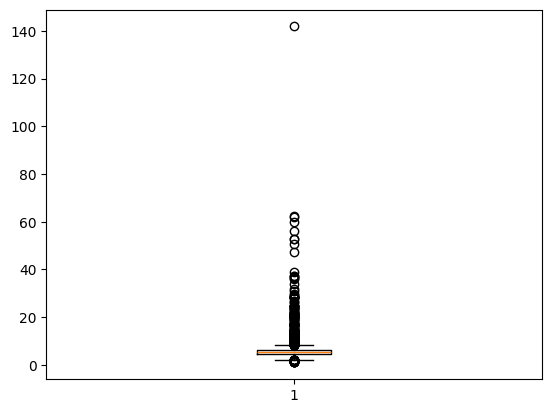

In [9]:
plt.boxplot(train['TotalRooms'])

{'whiskers': [<matplotlib.lines.Line2D at 0x79f023338620>,
 'caps': [<matplotlib.lines.Line2D at 0x79f0233374d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x79f0233383b0>],
 'medians': [<matplotlib.lines.Line2D at 0x79f023339580>],
 'fliers': [<matplotlib.lines.Line2D at 0x79f023339820>],
 'means': []}

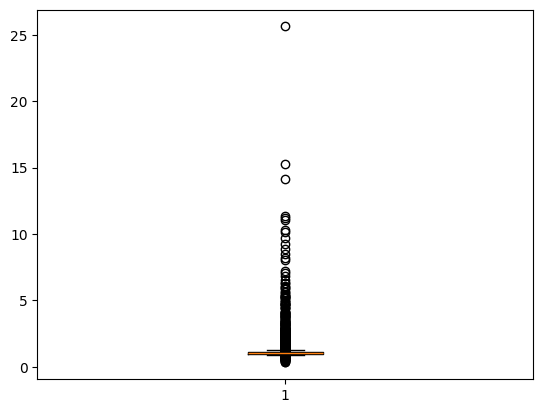

In [10]:
plt.boxplot(train['TotalBedrooms'])

{'whiskers': [<matplotlib.lines.Line2D at 0x79f023b798e0>,
 'caps': [<matplotlib.lines.Line2D at 0x79f023b79e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x79f023b79640>],
 'medians': [<matplotlib.lines.Line2D at 0x79f023b7a3f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x79f023b7a6f0>],
 'means': []}

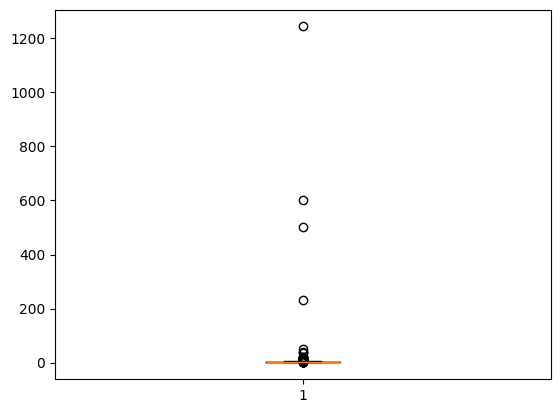

In [11]:
plt.boxplot(train['AvgOccupancy'])

The boxplots concluded that there is a strong skewness and extreme values in some features. Since the outliers amount is huge, I will not remove the entire rows, instead use tree based models

## Feature Engineering

In [12]:
features = ['IncomeLevel','PropertyAge','TotalRooms','TotalBedrooms','NeighborhoodPop','AvgOccupancy','RoomsPerHousehold','BedroomsRatio','Latitude','Longitude']

x = train[features].copy()
y = train['TargetPrice']

x_test = test[features].copy()

I kept preprocessing basic instead of doing heavy feature engineering, since the goal was to build a reliable baseline model first.

In [13]:
print(x.shape)
print(x_test.shape)

(16512, 10)
(4128, 10)


In [14]:
from sklearn.impute import SimpleImputer

In [15]:
imputer = SimpleImputer(strategy='median')

x['PropertyAge'] = imputer.fit_transform(x[['PropertyAge']])
x_test['PropertyAge'] = imputer.transform(x_test[['PropertyAge']])

SimpleImputer may not be the most optimal method, but it works consistently for this dataset.


I used median imputation for `PropertyAge` because the feature
contains outliers and is not symmetrically distributed.

In [16]:
x.isnull().sum()

IncomeLevel          0
PropertyAge          0
TotalRooms           0
TotalBedrooms        0
NeighborhoodPop      0
AvgOccupancy         0
RoomsPerHousehold    0
BedroomsRatio        0
Latitude             0
Longitude            0
dtype: int64

In [17]:
x_test.isnull().sum()

IncomeLevel          0
PropertyAge          0
TotalRooms           0
TotalBedrooms        0
NeighborhoodPop      0
AvgOccupancy         0
RoomsPerHousehold    0
BedroomsRatio        0
Latitude             0
Longitude            0
dtype: int64

In [18]:
for col in ['NeighborhoodPop', 'AvgOccupancy', 'TotalRooms']:
    x[col] = np.log1p(x[col].clip(lower=0))
    x_test[col] = np.log1p(x_test[col].clip(lower=0))

Some count-based features are heavily skewed.
Applying a log transformation helps reduce the influence
of extreme values and makes the data easier for models to learn from.

In [19]:
print(x[['NeighborhoodPop', 'AvgOccupancy', 'TotalRooms']].min())

NeighborhoodPop    0.000000
AvgOccupancy       0.456847
TotalRooms         0.679907
dtype: float64


By using log transformation, we can see that there are no negative values, I removed the negative values found in neighbourhoodpop, also average occupancy and total rooms are transformed better with log transformations.

# Model Building

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, random_state=42)

Tried a standard split instead of cross-validation to keep runtime reasonable on my system.

In [22]:
from sklearn.metrics import root_mean_squared_error

In [23]:
linear = LinearRegression()
linear.fit(X_train, y_train)

linear_val_pred = linear.predict(X_val)
linear_rmse = root_mean_squared_error(y_val, linear_val_pred)
print("Linear Regression Validation RMSE:", linear_rmse)

Linear Regression Validation RMSE: 0.6793237972564906


After trying a linera regression model as a base model, I got a high RMSE, means there is high complexity in the data.

## XGBoost
Instead of spending time manually removing outliers, I decided to try tree-based models first to see if they could handle the data as-is.


In [24]:
from xgboost import XGBRegressor

In [25]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

In [26]:
xgb = XGBRegressor(
    n_estimators=2500,
    learning_rate=0.01,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(x, y)
xgb_train_pred = xgb.predict(x)
xgb_rmse = root_mean_squared_error(y, xgb_train_pred)

print("XGBoost Train RMSE:", xgb_rmse)


XGBoost Train RMSE: 0.13983994698831823


Started with this model because simpler model was underfitting and I wanted something more flexible without too much tuning.


In [27]:
xgb_test_predictions = xgb.predict(x_test)

print(len(xgb_test_predictions))
print(np.unique(xgb_test_predictions[:10]))

4128
[0.48700297 0.81847566 1.5650002  1.6541369  2.2908347  2.3301318
 2.5397568  3.0390146  4.796372   5.216995  ]


The training RMSE is quite low, which means that the model is able to fit the training data well. But this alone does not guarantee
good generalization, so additional models and ensembling are explored.

## CatBoost
Since the target variable was heavily right-skewed,
I also tried training CatBoost on a log-transformed target to see if it would reduce large errors.


In [28]:
from catboost import CatBoostRegressor

In [29]:
y_log = np.log1p(y)

cat_log = CatBoostRegressor(
    iterations=3000,
    learning_rate=0.03,
    depth=8,
    loss_function='RMSE',
    random_seed=42,
    verbose=200
)

cat_log.fit(x, y_log)

train_pred_log = cat_log.predict(x)
train_pred = np.expm1(train_pred_log)

train_rmse = np.sqrt(mean_squared_error(y, train_pred))
print("CatBoost (log target) Train RMSE:", train_rmse)

0:	learn: 0.3504948	total: 58.2ms	remaining: 2m 54s
200:	learn: 0.1477783	total: 1.14s	remaining: 15.9s
400:	learn: 0.1313202	total: 2.29s	remaining: 14.8s
600:	learn: 0.1203296	total: 3.34s	remaining: 13.3s
800:	learn: 0.1119763	total: 4.44s	remaining: 12.2s
1000:	learn: 0.1055075	total: 5.52s	remaining: 11s
1200:	learn: 0.1001589	total: 6.58s	remaining: 9.86s
1400:	learn: 0.0954195	total: 7.62s	remaining: 8.7s
1600:	learn: 0.0912547	total: 8.72s	remaining: 7.62s
1800:	learn: 0.0876456	total: 9.8s	remaining: 6.53s
2000:	learn: 0.0842412	total: 10.9s	remaining: 5.44s
2200:	learn: 0.0811389	total: 12s	remaining: 4.37s
2400:	learn: 0.0782900	total: 13.1s	remaining: 3.28s
2600:	learn: 0.0755951	total: 14.2s	remaining: 2.18s
2800:	learn: 0.0730859	total: 15.3s	remaining: 1.08s
2999:	learn: 0.0707485	total: 16.4s	remaining: 0us
CatBoost (log target) Train RMSE: 0.24652485599657928


The RMSE is worse than xgboost, so I will need a more better way to handle the complexities.

In [30]:
cat_test_pred_log = cat_log.predict(x_test)
cat_test_predictions = np.expm1(cat_test_pred_log)

In [31]:
final_prediction = 0.5 * xgb_test_predictions + 0.5 * cat_test_predictions

Since CatBoost handles noise and feature interactions differently,I combined its predictions with XGBoost using a simple average.

The ensemble is a simple average. A weighted approach could improve performance, but was not explored due to time constraints.


In [32]:
combined_train_pred = 0.5 * xgb_train_pred + 0.5 * train_pred
combined_train_rmse = root_mean_squared_error(y, combined_train_pred)
print("Combined Train RMSE:", combined_train_rmse)

Combined Train RMSE: 0.18958716476949555


Results are decent but not perfect. Some variance is expected due to the simplicity of the preprocessing.

In [33]:
submission_df = pd.DataFrame({
    'PropertyID': test['PropertyID'],
    'TargetPrice': final_prediction
})

submission_df.to_csv('submission.csv', index=False)

In [34]:
print(submission.shape)
print(submission.head())
print(submission['TargetPrice'].nunique())

(4128, 2)
   PropertyID  TargetPrice
0  PROP_20046     2.071947
1  PROP_03024     2.071947
2  PROP_15663     2.071947
3  PROP_20484     2.071947
4  PROP_09814     2.071947
1


## Limitations

- Hyperparameter tuning was limited.
- Cross-validation was not performed due to time constraints.
- Feature engineering was restricted to basic transformations.
- The ensemble method was a simple average and not optimized.


There are cleaner ways to structure this, but this version is easier for me to follow.